# 生pythonで正規化したロジスティック回帰
製造工場からのマイクロチップが品質保証に合格しているかどうかを予測する。
試験結果1(x1)と試験結果2(x2)から合格しているか(y)を分類する

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plot
from scipy import optimize

### 教師データを可視化する

```
matplotlibを使ってXとyの可視化を行う関数
```

In [2]:
def plot_data(X, y):
    pos = y.nonzero()[0]
    neg = (y == 0).nonzero()[0]
    plot.plot(X[pos, 0], X[pos, 1], 'k+', markersize=7, linewidth=2)
    plot.plot(X[neg, 0], X[neg, 1], 'ko', markerfacecolor='y', markersize=7, linewidth=2)
    plot.xlabel('Exam 1 score')
    plot.ylabel('Exam 2 score')

### シグモイド関数



In [3]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

### コスト関数



In [4]:
def cost_function(theta, X, y):
    m = X.shape[0]
    h = sigmoid(X.dot(theta))
    cost = sum(-y * np.log(h) - (1.0 - y) * np.log(1.0 - h))
    grad = X.T.dot(h - y)
    return (cost / m, grad / m)

### 分類結果



In [5]:
def predict(theta, X):
    return sigmoid(X.dot(theta)) >= 0.5

### フィーチャーマッピング



In [6]:
def map_feature(X1, X2, degree=6):
    """
    特徴の多項式を作成、より多くの特徴配列にして返す
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    """
    m = X1.shape[0] if X1.shape else 1
    cols = [np.ones(m)]
    for i in range(1, degree + 1):
        for j in range(i + 1):
            cols.append((X1 ** (i - j)) * (X2 ** j))
    return np.vstack(cols).T

### 正規化したロジスティック回帰



In [7]:
def cost_function_reg(theta, X, y, _lambda):
    """
    正規化したロジスティック回帰とコスト関数
    """
    m = X.shape[0]
    cost, gradient = cost_function(theta, X, y)
    reg_cost = (_lambda / (2.0 * m)) * np.sum(theta[1:] ** 2)
    reg_gradient = (_lambda / m) * theta
    reg_gradient[0] = 0
    return cost + reg_cost, gradient + reg_gradient

In [8]:
# データのロード、変数の初期化
data1 = np.loadtxt('./assets/data4.txt', delimiter=',')
X_original = X = data1[:, 0:2]
y = data1[:, 2]

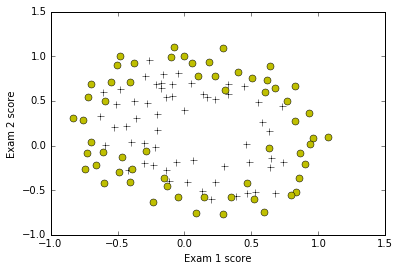

In [9]:
# トレーニングデータの可視化
plot_data(X, y)

In [10]:
# 特徴の多項式を作成、より多くの特徴配列にする
X = map_feature(X[:, 0], X[:, 1])
m, n = X.shape
initial_theta = np.zeros(n)

In [11]:
# 1回で出したコストcostを表示
_lambda = 1.0
cost, grad = cost_function_reg(initial_theta, X, y, _lambda)
print('Cost at initial theta (zeros): %f' % cost)

Cost at initial theta (zeros): 0.693147


In [12]:
# scipy.optimizeを利用してcostの最小値を探す
loops = 400
result = optimize.minimize(
    cost_function_reg,
    initial_theta,
    args=(X, y, _lambda),
    method='CG',
    jac=True,
    options={
        'maxiter': loops,
        'disp': False,
    }
)
theta = result.x
cost = result.fun

In [13]:
# scipy.optimizeを利用して指定回数ループして探した最小値のcostを表示
print('Cost at theta found by scipy.optimize.minimize: %f' % cost)

Cost at theta found by scipy.optimize.minimize: 0.529003


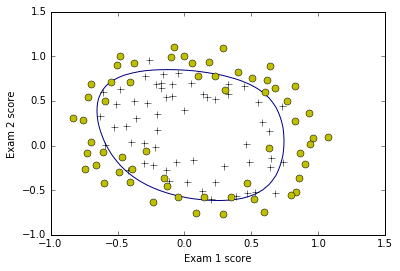

In [14]:
# 決定境界の表示
plot_data(X_original, y)
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((u.size, v.size))
for i in range(u.size):
    for j in range(v.size):
        z[i, j] = map_feature(u[i], v[j]).dot(theta)
plot.contour(u, v, z.T, 0)
plot.show()

In [15]:
# 予測値の出力 (plot図から、試験結果は中央の0に近ければ合格率が高い)
test_data = [
    [0.1, -0.1],
    [-0.7, 0.2],
    [0.8, -0.1],
    [1.0, -1.0]
]
for data in test_data:
    test1 = data[0]
    test2 = data[1]
    x = map_feature(np.array(test1), np.array(test2))
    prob = sigmoid(np.array(x).dot(theta))
    print('試験結果が{}と{}だったマイクロチップが品質保証に合格している確率は{}'.format(test1, test2, prob))

試験結果が0.1と-0.1だったマイクロチップが品質保証に合格している確率は[ 0.76704059]
試験結果が-0.7と0.2だったマイクロチップが品質保証に合格している確率は[ 0.40792773]
試験結果が0.8と-0.1だったマイクロチップが品質保証に合格している確率は[ 0.3918064]
試験結果が1.0と-1.0だったマイクロチップが品質保証に合格している確率は[ 0.00138481]


In [16]:
# 精度の表示
predictions = predict(theta, X)
accuracy = 100 * np.mean(predictions == y)
print('Train accuracy: %0.2f %%' % accuracy)

Train accuracy: 83.05 %
